In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import numpy as np
import datetime as dt
from pathlib import Path
from collections import Counter
import pandas as pd
import tensorflow as tf

#  Import and read the fraudtrain.csv.
import pandas as pd 
ccf_df = pd.read_csv("Resources/fraudtrain.csv")

# Drop any null columns
ccf_df=ccf_df.dropna(axis='columns', how='all')
ccf_df.drop_duplicates(inplace=True)

# Drop all null rows
ccf_df= ccf_df.dropna()

# Preview 
ccf_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [33]:
# Create a function to label states by region
def label_states (row):
    if row['state'] in ['VT', 'ME', 'NH', 'MA', 'RI', 'CT','NY','PA','NJ']:
        return 'North-East'
    if row['state'] in ['WI','MI','IL','IN','OH','ND','SD','NE','KS','MN','IA','MO']:
        return 'Mid-West'
    if row['state'] in ['DE','MD','DC','VA','WV','NC','SC','GA','FL','KY','TN','MS','AL','AR','LA']:
        return 'South-East'
    if row['state'] in ['OK','TX','NM','AZ']:
        return 'South-West'
    if row['state'] in ['CA','NV','UT','CO','WY','ID','OR','WA','MT','AK','HI']:
        return 'West'
    return 'etc'

In [35]:
# Add regions to each row of data
ccf_df['Region']=ccf_df.apply(lambda row: label_states(row), axis=1)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import plotly.express as px
sns.set(rc = {'figure.figsize':(15,8)})
df=pd.read_csv('Resources/fraudtrain.csv') 
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [37]:
ccf_df['amt'].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [38]:
np.percentile(ccf_df['amt'],99)

545.9926000000002

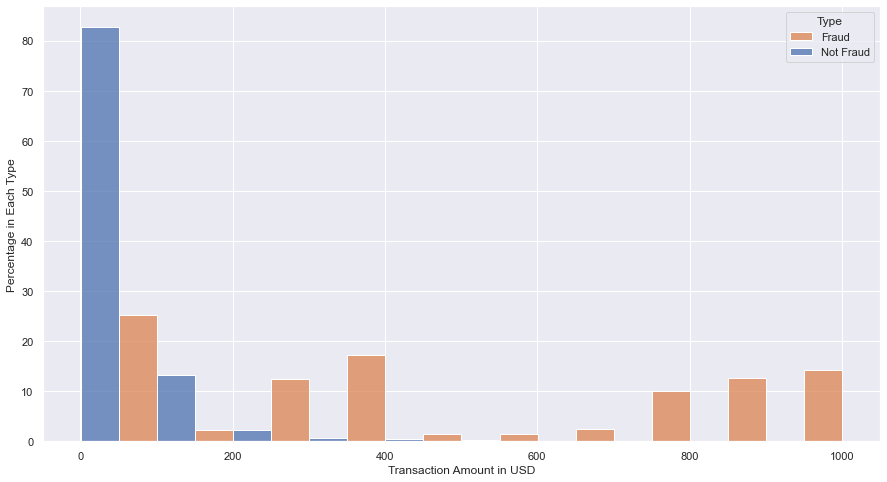

In [39]:
#amount vs fraud
ax=sns.histplot(x='amt',data=ccf_df[ccf_df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=10)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

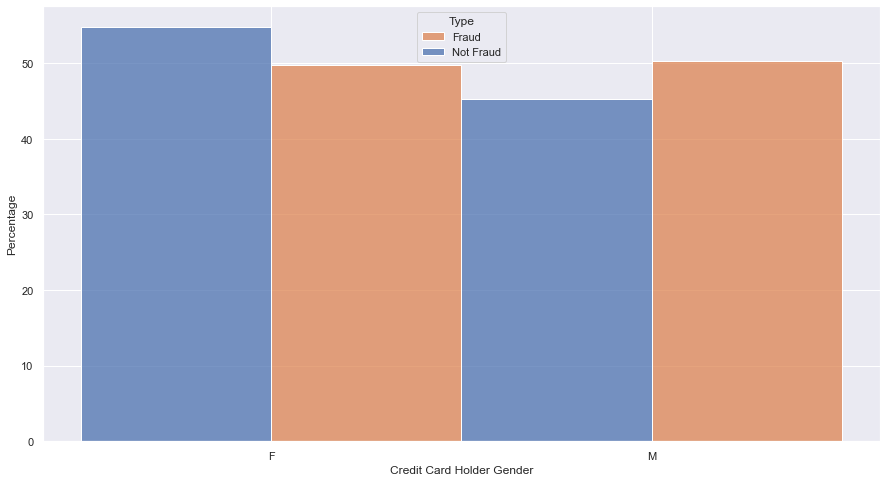

In [41]:
#Gender vs Fraud
ax=sns.histplot(x='gender',data=ccf_df, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Card Holder Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent vs Non-Fraudulent Per Transaction Type')

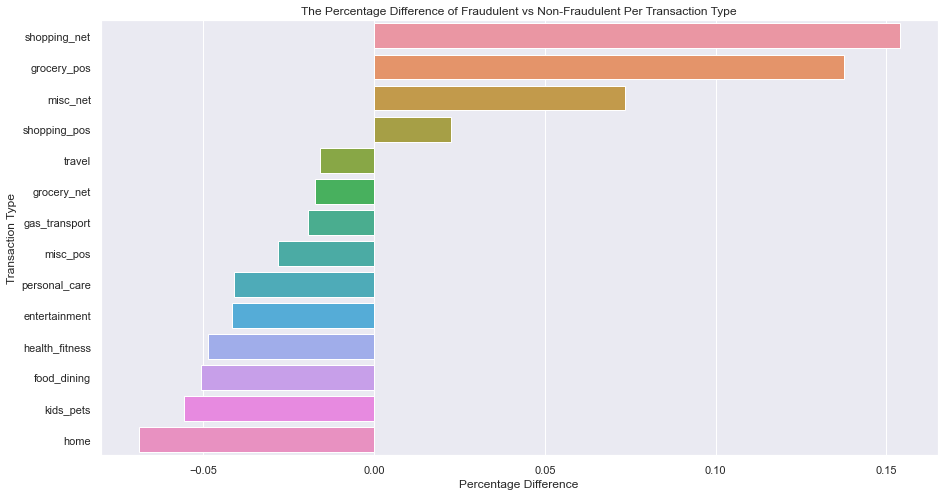

In [42]:
#calculate the percentage difference
a=ccf_df[ccf_df['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=ccf_df[ccf_df['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Type')
plt.title('The Percentage Difference of Fraudulent vs Non-Fraudulent Per Transaction Type')

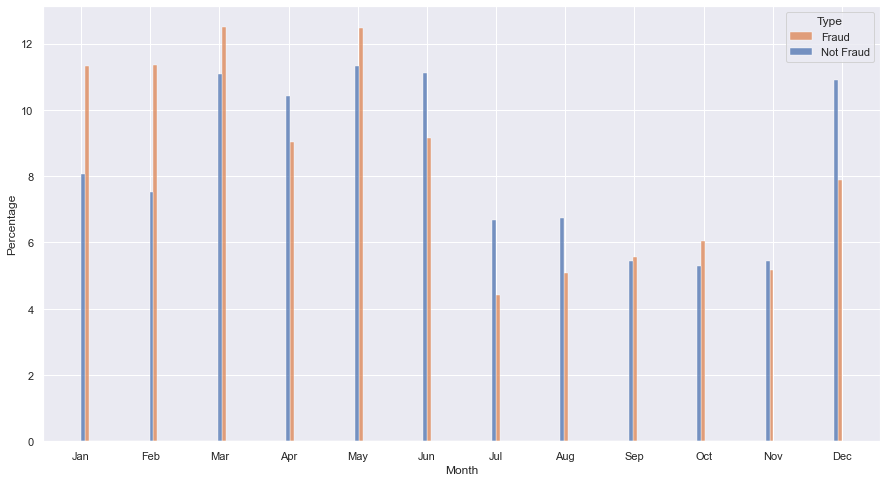

In [30]:
#month vs fraud
ccf_df['month']=pd.to_datetime(ccf_df['trans_date_trans_time']).dt.month
ax=sns.histplot(data=ccf_df, x="month", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in US Region')

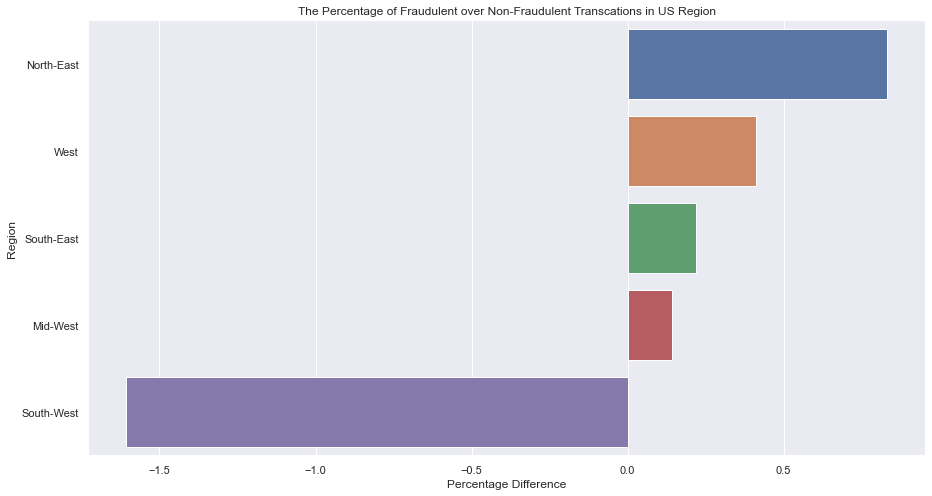

In [44]:
a=ccf_df['Region'][ccf_df.is_fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['Region', 'Per']

b=ccf_df['Region'][ccf_df.is_fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['Region', 'Per']
merged=a.merge(b,on='Region')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='Region')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('Region')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in US Region')